In [1]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *
palette_tab10 = sns.color_palette("tab10", 10)

In [2]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    from bids import BIDSLayout
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, 
        desc = desc
        )
    print(fnames)
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    for epochs in epochs_all:
        print(epochs.info['sfreq'])
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

In [3]:
# Load accuracies
accuracies = pd.read_csv('accuracies.csv')

In [4]:
# Load ERPs
evokeds = pd.read_csv('evokeds.csv')
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,1,1,high,-173,-8.727872e-08
1,10,Cz,True,1,1,high,-172,-9.012204e-08
2,10,Cz,True,1,1,high,-171,-1.052924e-07
3,10,Cz,True,1,1,high,-170,-1.171627e-07
4,10,Cz,True,1,1,high,-169,-1.369268e-07
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,3,3,high,522,5.592560e-07
1984496,41,Pz,False,3,3,high,523,5.489198e-07
1984497,41,Pz,False,3,3,high,524,5.435890e-07
1984498,41,Pz,False,3,3,high,525,5.367600e-07


In [5]:
# Rename target and tone vars to freq
mapping = {1: 110,
           2: 150,
           3: 210}

evokeds['target'] = evokeds['target'].replace(mapping)
evokeds['tone'] = evokeds['tone'].replace(mapping)
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,110,110,high,-173,-8.727872e-08
1,10,Cz,True,110,110,high,-172,-9.012204e-08
2,10,Cz,True,110,110,high,-171,-1.052924e-07
3,10,Cz,True,110,110,high,-170,-1.171627e-07
4,10,Cz,True,110,110,high,-169,-1.369268e-07
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,210,210,high,522,5.592560e-07
1984496,41,Pz,False,210,210,high,523,5.489198e-07
1984497,41,Pz,False,210,210,high,524,5.435890e-07
1984498,41,Pz,False,210,210,high,525,5.367600e-07


In [6]:
# Adjust EEG units
evokeds['uV'] = evokeds['uV'] * 1000000 - 0.30
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,110,110,high,-173,-0.387279
1,10,Cz,True,110,110,high,-172,-0.390122
2,10,Cz,True,110,110,high,-171,-0.405292
3,10,Cz,True,110,110,high,-170,-0.417163
4,10,Cz,True,110,110,high,-169,-0.436927
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,210,210,high,522,0.259256
1984496,41,Pz,False,210,210,high,523,0.248920
1984497,41,Pz,False,210,210,high,524,0.243589
1984498,41,Pz,False,210,210,high,525,0.236760


In [7]:
# Adjust EEG timing according to lag
evokeds['msec'] = evokeds['msec'] - 27

In [8]:
# Drop subjects with fewer than 80% trials
BADS = [33, 37]
for bad in BADS:
    evokeds = evokeds[evokeds['sub'] != bad]
np.unique(evokeds['sub'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

# Plot by target

In [9]:
evokeds_Cz = evokeds[evokeds.chan == 'Cz']

In [10]:
# Label data as target vs distractor
evokeds_target = evokeds_Cz

# Rename target and tone vars to freq
target_110 = {110: True,
              150: False,
              210: False}
target_150 = {110: False,
              150: True,
              210: False}
target_210 = {110: False,
              150: False,
              210: True}

evokeds_target['target_110'] = evokeds_target['target'].replace(target_110)
evokeds_target['target_150'] = evokeds_target['target'].replace(target_150)
evokeds_target['target_210'] = evokeds_target['target'].replace(target_210)

/scratch/local/jobs/21991092/ipykernel_2897508/2490691259.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evokeds_target['target_110'] = evokeds_target['target'].replace(target_110)
/scratch/local/jobs/21991092/ipykernel_2897508/2490691259.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evokeds_target['target_150'] = evokeds_target['target'].replace(target_150)
/scratch/local/jobs/21991092/ipykernel_2897508/2490691259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

### 110 Hz target

In [11]:
evokeds_110 = evokeds_target[evokeds_target.tone == 110]
evokeds_110 = evokeds_110.groupby(['sub', 'tone', 'target_110', 'msec'], as_index = False)['uV'].mean()
evokeds_110_target = evokeds_110.uV[evokeds_110.target_110 == True].reset_index(drop = True)
evokeds_110_distractor = evokeds_110.uV[evokeds_110.target_110 == False].reset_index(drop = True)
evokeds_110_ND = evokeds_110[evokeds_110.target_110 == True].reset_index(drop = True)
evokeds_110_ND['uV'] = evokeds_110_target - evokeds_110_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/4243161185.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_110_ND, x = "msec", y = "uV", palette = 'tab10', color = 'grey', ax = ax)


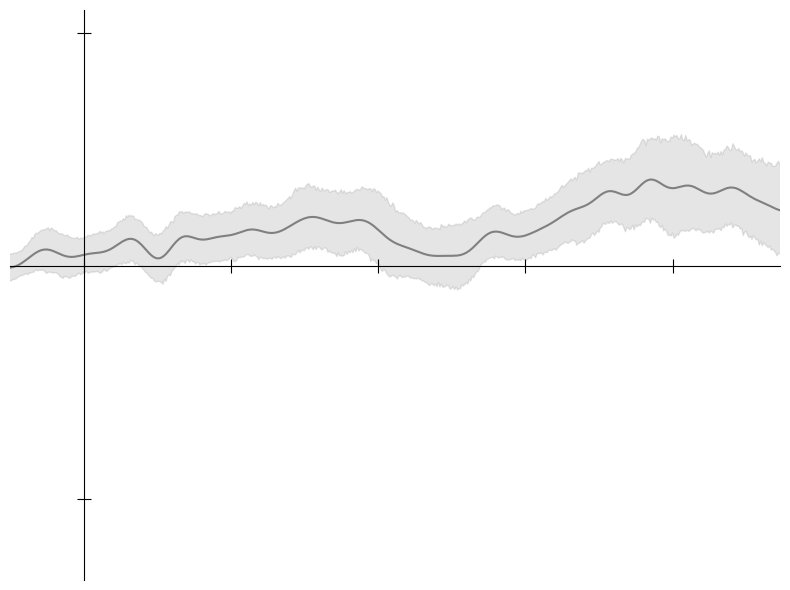

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_110_ND, x = "msec", y = "uV", palette = 'tab10', color = 'grey', ax = ax)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-1.png')

### 150 Hz target

In [13]:
evokeds_150 = evokeds_target[evokeds_target.tone == 150]
evokeds_150 = evokeds_150.groupby(['sub', 'tone', 'target_150', 'msec'], as_index = False)['uV'].mean()
evokeds_150_target = evokeds_150.uV[evokeds_150.target_150 == True].reset_index(drop = True)
evokeds_150_distractor = evokeds_150.uV[evokeds_150.target_150 == False].reset_index(drop = True)
evokeds_150_ND = evokeds_150[evokeds_150.target_150 == True].reset_index(drop = True)
evokeds_150_ND['uV'] = evokeds_150_target - evokeds_150_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/71723770.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_150_ND, x = "msec", y = "uV", palette = 'tab10', color = 'grey', ax = ax)


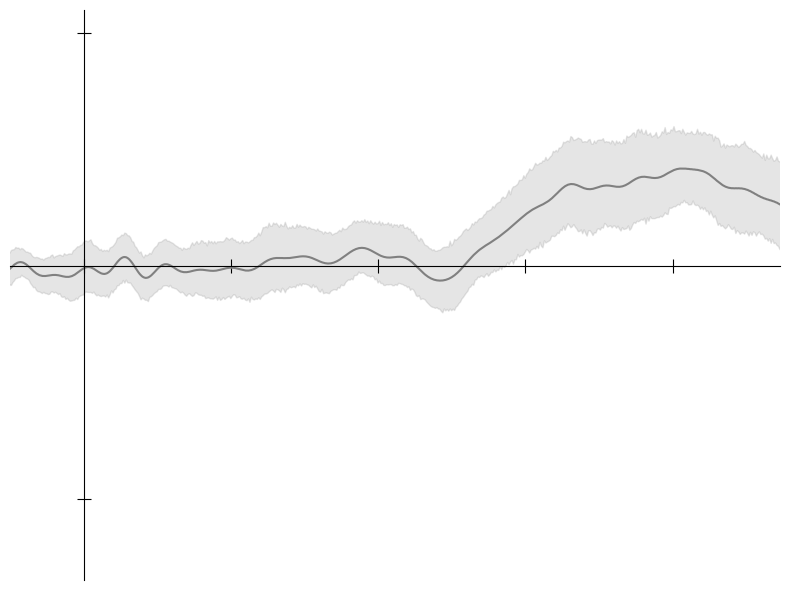

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_150_ND, x = "msec", y = "uV", palette = 'tab10', color = 'grey', ax = ax)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-2.png')

### 210 Hz target

In [15]:
evokeds_210 = evokeds_target[evokeds_target.tone == 210]
evokeds_210 = evokeds_210.groupby(['sub', 'tone', 'target_210', 'msec'], as_index = False)['uV'].mean()
evokeds_210_target = evokeds_210.uV[evokeds_210.target_210 == True].reset_index(drop = True)
evokeds_210_distractor = evokeds_210.uV[evokeds_210.target_210 == False].reset_index(drop = True)
evokeds_210_ND = evokeds_210[evokeds_210.target_210 == True].reset_index(drop = True)
evokeds_210_ND['uV'] = evokeds_210_target - evokeds_210_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/4237171765.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_210_ND, x = "msec", y = "uV", palette = 'tab10', color = 'grey', ax = ax)


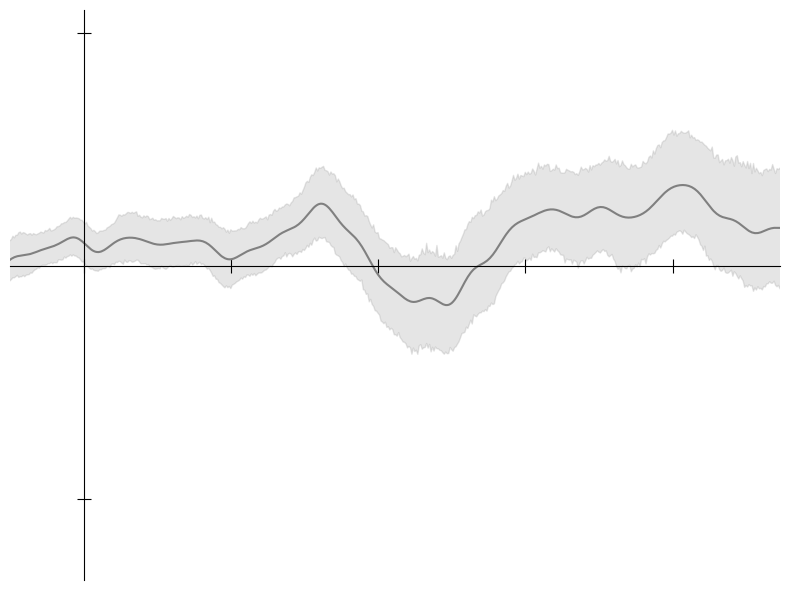

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_210_ND, x = "msec", y = "uV", palette = 'tab10', color = 'grey', ax = ax)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-3.png')

## Plot by accuracy

In [45]:
# Label data as target vs distractor
evokeds_target = evokeds_Cz

# Rename target and tone vars to freq
target_110 = {110: True,
              150: False,
              210: False}
target_150 = {110: False,
              150: True,
              210: False}
target_210 = {110: False,
              150: False,
              210: True}

evokeds_target['target_110'] = evokeds_target['target'].replace(target_110)
evokeds_target['target_150'] = evokeds_target['target'].replace(target_150)
evokeds_target['target_210'] = evokeds_target['target'].replace(target_210)

/scratch/local/jobs/21991092/ipykernel_2897508/2490691259.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evokeds_target['target_110'] = evokeds_target['target'].replace(target_110)
/scratch/local/jobs/21991092/ipykernel_2897508/2490691259.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evokeds_target['target_150'] = evokeds_target['target'].replace(target_150)
/scratch/local/jobs/21991092/ipykernel_2897508/2490691259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [46]:
evokeds_110 = evokeds_target[(evokeds_target.tone == 110) & (evokeds_target.tone == 110)]
evokeds_110 = evokeds_110.groupby(['sub', 'tone', 'target_110', 'accuracy', 'msec'], as_index = False)['uV'].mean()
evokeds_110_target = evokeds_110.uV[evokeds_110.target_110 == True].reset_index(drop = True)
evokeds_110_distractor = evokeds_110.uV[evokeds_110.target_110 == False].reset_index(drop = True)
evokeds_110_ND = evokeds_110[evokeds_110.target_110 == True].reset_index(drop = True)
evokeds_110_ND['uV'] = evokeds_110_target - evokeds_110_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/524742395.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_110_ND, x = "msec", y = "uV", palette = 'tab10', style = 'accuracy', color = 'grey', ax = ax, legend = False)


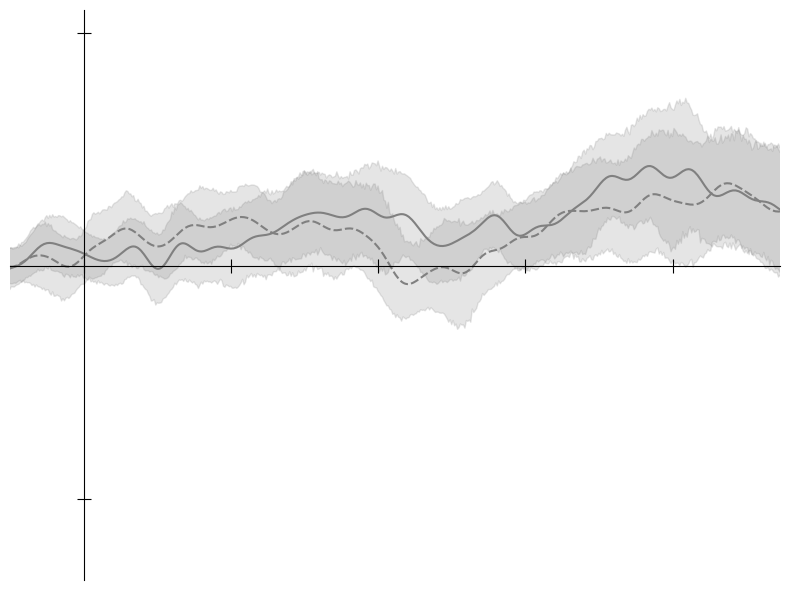

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_110_ND, x = "msec", y = "uV", palette = 'tab10', style = 'accuracy', color = 'grey', ax = ax, legend = False)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-1-by-accuracy.png')

### 150 Hz target

In [48]:
evokeds_150 = evokeds_target[(evokeds_target.tone == 150) & (evokeds_target.tone == 150)]
evokeds_150 = evokeds_150.groupby(['sub', 'tone', 'target_150', 'accuracy', 'msec'], as_index = False)['uV'].mean()
evokeds_150_target = evokeds_150.uV[evokeds_150.target_150 == True].reset_index(drop = True)
evokeds_150_distractor = evokeds_150.uV[evokeds_150.target_150 == False].reset_index(drop = True)
evokeds_150_ND = evokeds_150[evokeds_150.target_150 == True].reset_index(drop = True)
evokeds_150_ND['uV'] = evokeds_150_target - evokeds_150_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/1313064353.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_150_ND, x = "msec", y = "uV", palette = 'tab10', style = 'accuracy', color = 'grey', ax = ax, legend = False)


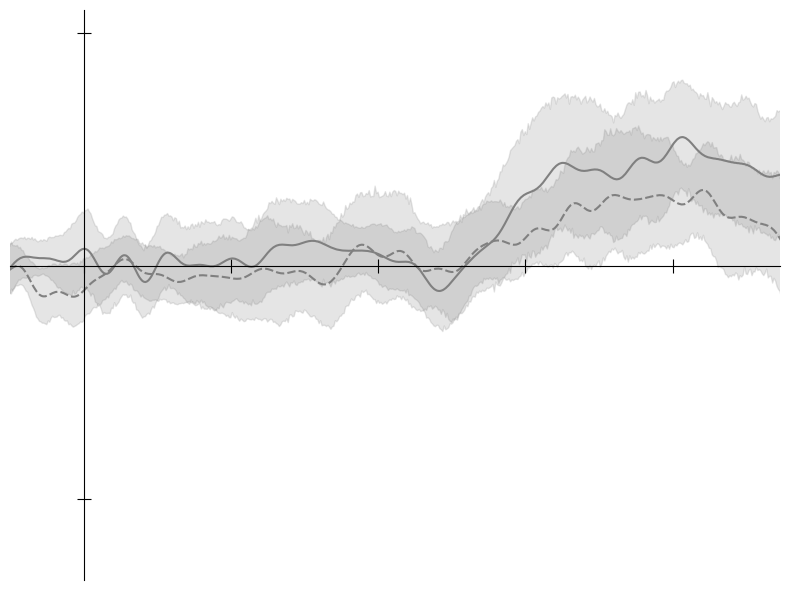

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_150_ND, x = "msec", y = "uV", palette = 'tab10', style = 'accuracy', color = 'grey', ax = ax, legend = False)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-2-by-accuracy.png')

### 210 Hz target

In [50]:
evokeds_210 = evokeds_target[(evokeds_target.tone == 210) & (evokeds_target.tone == 210)]
evokeds_210 = evokeds_210.groupby(['sub', 'tone', 'target_210', 'accuracy', 'msec'], as_index = False)['uV'].mean()
evokeds_210_target = evokeds_210.uV[evokeds_210.target_210 == True].reset_index(drop = True)
evokeds_210_distractor = evokeds_210.uV[evokeds_210.target_210 == False].reset_index(drop = True)
evokeds_210_ND = evokeds_210[evokeds_210.target_210 == True].reset_index(drop = True)
evokeds_210_ND['uV'] = evokeds_210_target - evokeds_210_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/2866630639.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_210_ND, x = "msec", y = "uV", palette = 'tab10', style = 'accuracy', color = 'grey', ax = ax, legend = False)


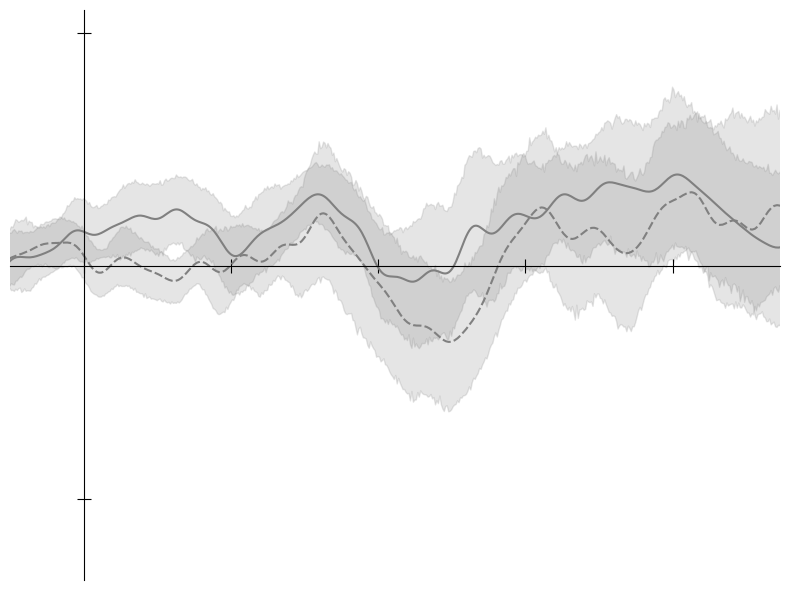

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_210_ND, x = "msec", y = "uV", palette = 'tab10', style = 'accuracy', color = 'grey', ax = ax, legend = False)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-3-by-accuracy.png')

## Plot by predictability

In [52]:
# Rename target and tone vars to freq
target_110 = {110: True,
              150: False,
              210: False}
target_150 = {110: False,
              150: True,
              210: False}
target_210 = {110: False,
              150: False,
              210: True}

evokeds_target['target_110'] = evokeds_target['target'].replace(target_110)
evokeds_target['target_150'] = evokeds_target['target'].replace(target_150)
evokeds_target['target_210'] = evokeds_target['target'].replace(target_210)

/scratch/local/jobs/21991092/ipykernel_2897508/4127697373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evokeds_target['target_110'] = evokeds_target['target'].replace(target_110)
/scratch/local/jobs/21991092/ipykernel_2897508/4127697373.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evokeds_target['target_150'] = evokeds_target['target'].replace(target_150)
/scratch/local/jobs/21991092/ipykernel_2897508/4127697373.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [53]:
evokeds_110 = evokeds_target[(evokeds_target.tone == 110) & (evokeds_target.tone == 110)]
evokeds_110 = evokeds_110.groupby(['sub', 'tone', 'target_110', 'predictable', 'msec'], as_index = False)['uV'].mean()
evokeds_110_target = evokeds_110.uV[evokeds_110.target_110 == True].reset_index(drop = True)
evokeds_110_distractor = evokeds_110.uV[evokeds_110.target_110 == False].reset_index(drop = True)
evokeds_110_ND = evokeds_110[evokeds_110.target_110 == True].reset_index(drop = True)
evokeds_110_ND['uV'] = evokeds_110_target - evokeds_110_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/641582992.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_110_ND, x = "msec", y = "uV", palette = 'tab10', style = 'predictable', color = 'grey', ax = ax, legend = False)


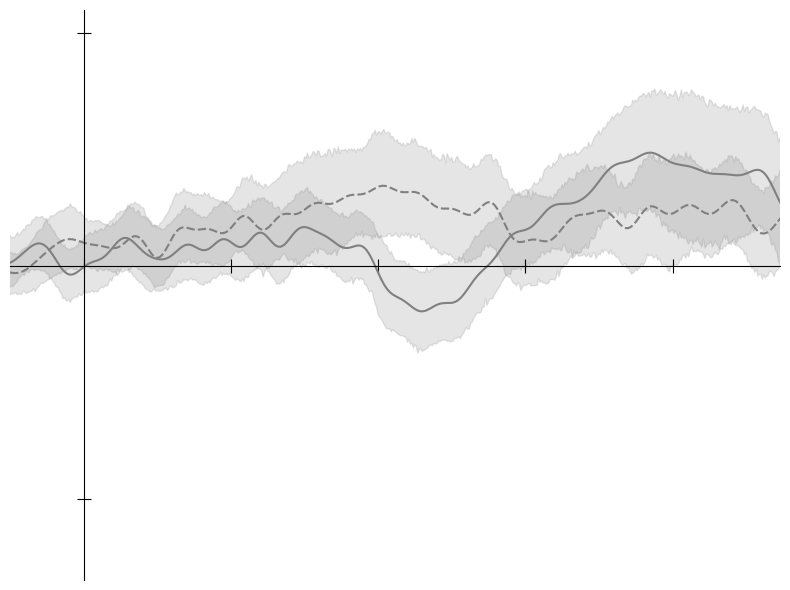

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_110_ND, x = "msec", y = "uV", palette = 'tab10', style = 'predictable', color = 'grey', ax = ax, legend = False)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-1-by-predictability.png')

In [55]:
evokeds_150 = evokeds_target[(evokeds_target.tone == 150) & (evokeds_target.tone == 150)]
evokeds_150 = evokeds_150.groupby(['sub', 'tone', 'target_150', 'predictable', 'msec'], as_index = False)['uV'].mean()
evokeds_150_target = evokeds_150.uV[evokeds_150.target_150 == True].reset_index(drop = True)
evokeds_150_distractor = evokeds_150.uV[evokeds_150.target_150 == False].reset_index(drop = True)
evokeds_150_ND = evokeds_150[evokeds_150.target_150 == True].reset_index(drop = True)
evokeds_150_ND['uV'] = evokeds_150_target - evokeds_150_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/1593850734.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_150_ND, x = "msec", y = "uV", palette = 'tab10', style = 'predictable', color = 'grey', ax = ax, legend = False)


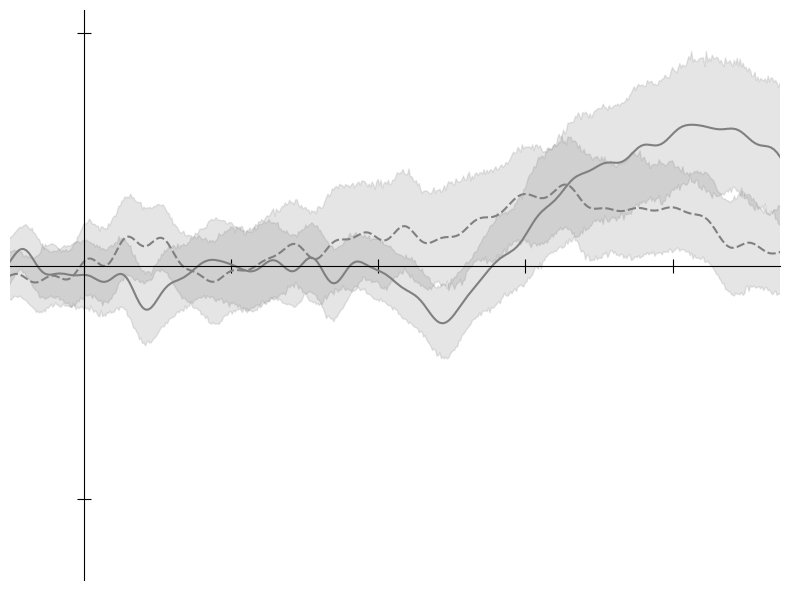

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_150_ND, x = "msec", y = "uV", palette = 'tab10', style = 'predictable', color = 'grey', ax = ax, legend = False)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-2-by-predictability.png')

In [57]:
evokeds_210 = evokeds_target[(evokeds_target.tone == 210) & (evokeds_target.tone == 210)]
evokeds_210 = evokeds_210.groupby(['sub', 'tone', 'target_210', 'predictable', 'msec'], as_index = False)['uV'].mean()
evokeds_210_target = evokeds_210.uV[evokeds_210.target_210 == True].reset_index(drop = True)
evokeds_210_distractor = evokeds_210.uV[evokeds_210.target_210 == False].reset_index(drop = True)
evokeds_210_ND = evokeds_210[evokeds_210.target_210 == True].reset_index(drop = True)
evokeds_210_ND['uV'] = evokeds_210_target - evokeds_210_distractor

/scratch/local/jobs/21991092/ipykernel_2897508/2684936525.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_210_ND, x = "msec", y = "uV", palette = 'tab10', style = 'predictable', color = 'grey', ax = ax, legend = False)


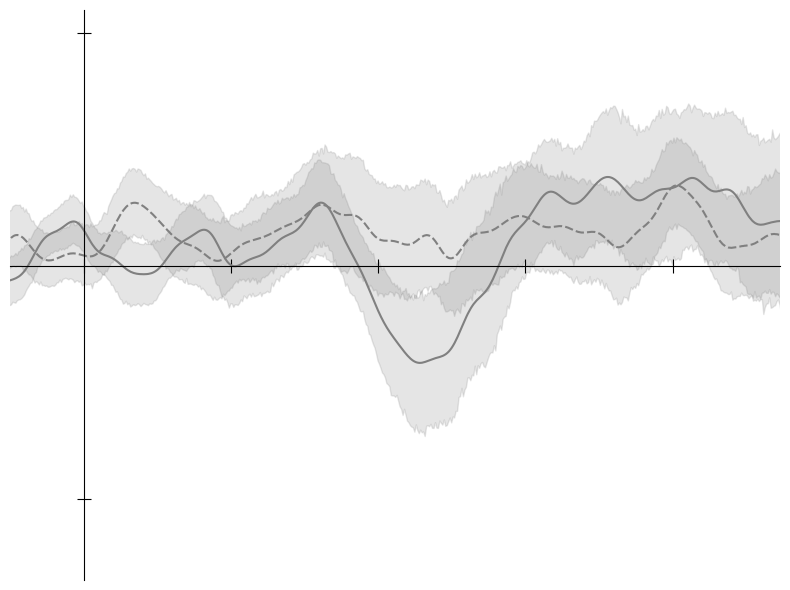

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))

# Formatting
sns.despine(top=True, right=True)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(length = 10, direction = 'inout')
ax.set_yticks([-1, 1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])

# Plot
graph = sns.lineplot(data = evokeds_210_ND, x = "msec", y = "uV", palette = 'tab10', style = 'predictable', color = 'grey', ax = ax, legend = False)
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 473)
graph.set_ylim(-1.35, 1.1)
plt.tight_layout()
plt.savefig('../figs/ND-tone-3-by-predictability.png')